## Created By : Shreya Dubey
## Sentiment Modification Model

In [1]:
from nltk.corpus import stopwords
import nltk
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import csv

Using TensorFlow backend.


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving classifier_data.csv to classifier_data.csv
User uploaded file "classifier_data.csv" with length 7513446 bytes


In [0]:
df = pd.read_csv('classifier_data.csv')
max_text_len = 30

def shorten_length(x,y):
  x_new = []
  y_new = []
  for i in range(len(x)):
    if(len(x[i].split())<=30):
      x_new.append(x[i])
      y_new.append(y[i])
  return x_new,y_new

x,y = shorten_length(df['text'],df['sentiments'])

In [0]:
from sklearn.model_selection import train_test_split
#train_data,test_data=train_test_split(df,test_size=0.1,shuffle=True)

#x_tr = train_data['text']
#x_val = test_data['text']
#y_tr = train_data['sentiments']
#y_val = test_data['sentiments']

x_tr,x_val,y_tr,y_val=train_test_split(x,y,test_size=0.1,shuffle=True)

In [5]:
# Building tokenizer to convert word sequence into integer sequence

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# Analysing the number of rare words in the vocabulary (rule: any word that appears 3 or leass times is rare)

thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for articles on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

% of rare words in vocabulary: 37.20587218547625
Total Coverage of rare words: 1.511136488086602


In [0]:
import tensorflow as tf
class Attention(Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [7]:
import os

sequence_input = Input(shape=(max_text_len,))
embed_seq = Embedding(x_voc, 100, input_length=max_text_len)(sequence_input)

rnn_cell_size = 100

lstm = Bidirectional(LSTM(rnn_cell_size,dropout=0.3,return_sequences=True,return_state=True,recurrent_activation='relu',recurrent_initializer='glorot_uniform'))(embed_seq)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(rnn_cell_size,dropout=0.2,return_sequences=True,return_state=True,recurrent_activation='relu',recurrent_initializer='glorot_uniform'))(lstm)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

attention = Attention(100)

context_vector, attention_weights = attention(lstm, state_h)
 
output = Dense(1, activation='sigmoid')(context_vector)
 
#classifier_model = Model(inputs=sequence_input, outputs=[output,attention_weights])
classifier_model = Model(inputs=sequence_input, outputs = output)
 
# summarize layers
print(classifier_model.summary())

y_tr = list(y_tr)
for i in range (len(y_tr)):
    y_tr[i] = float(y_tr[i])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      2724800     input_1[0][0]                    
_______________________________________________________

In [8]:
classifier_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
 
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
classifier_history = classifier_model.fit(x_tr,y_tr,epochs=10,batch_size=200,validation_split=.3, verbose=1, callbacks=[es])

Train on 31931 samples, validate on 13685 samples
Epoch 1/10
31931/31931 [==============================] - 26s 805us/sample - loss: 0.6397 - acc: 0.6728 - val_loss: 0.6134 - val_acc: 0.6756
Epoch 2/10
31931/31931 [==============================] - 23s 719us/sample - loss: 0.5633 - acc: 0.7076 - val_loss: 0.6181 - val_acc: 0.6730


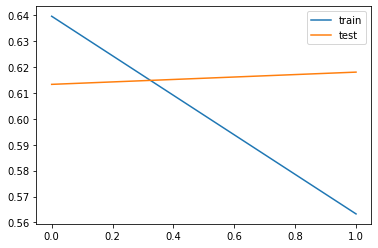

In [10]:
from matplotlib import pyplot
pyplot.plot(classifier_history.history['loss'], label='train')
pyplot.plot(classifier_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
classifier_model = Model(inputs=sequence_input, outputs=[output,attention_weights])
# getting attention weights

out = classifier_model.predict(x_tr)
trained_att = out[1]

In [0]:
a = (int)(np.sum(y_tr))
b = (int)(len(y_tr)-np.sum(y_tr))

In [13]:
print("shape of attention_weights = ", trained_att.shape)
new_trained_att = np.reshape(trained_att,(trained_att.shape[0],trained_att.shape[1]))
print("shape of attention_weights = ", new_trained_att.shape)

for i in range(new_trained_att.shape[0]):
    avg = np.mean(new_trained_att[i,:])
    for j in range(new_trained_att.shape[1]):
        if(new_trained_att[i,j]>=avg):
            new_trained_att[i,j]=1
        else:
            new_trained_att[i,j]=0

shape of attention_weights =  (45616, 30, 1)
shape of attention_weights =  (45616, 30)


In [0]:
x_pos = np.empty((a,max_text_len))
x_neg = np.empty((b,max_text_len))

att_pos = np.empty((a,max_text_len))
att_neg = np.empty((b,max_text_len))

p,n = 0,0

for i in range(len(y_tr)):
    if(y_tr[i]==1):
        x_pos[p,:] = x_tr[i,:]
        att_pos[p,:] = new_trained_att[i,:]
        p = p+1
    elif(y_tr[i]==0):
        x_neg[n,:] = x_tr[i,:]
        att_neg[n,:] = new_trained_att[i,:]
        n = n+1

In [0]:
context_attention = 1-att_pos
context_attention_neg = 1-att_neg
alpha = 60

In [0]:
att_pos = att_pos.astype('float32')
context_attention = context_attention.astype('float32')
att_neg = att_neg.astype('float32')
context_attention_neg = context_attention_neg.astype('float32')

In [0]:
class Memory(Model):
    def __init__(self, e, alpha):
        super(Memory, self).__init__()
        self.M_pos = np.ones((e,alpha))
 
    def call(self, att_pos, context_attention,encoder_embedding):
        s_pos = tf.reduce_sum(encoder_embedding*tf.expand_dims(att_pos,axis=-1),1)
        s_cont = tf.reduce_sum(encoder_embedding*tf.expand_dims(context_attention,axis=-1),1)
        #w = softmax((s_pos.T)@self.M_pos)
        w = tf.nn.softmax((s_pos@self.M_pos))
        self.M_pos = self.M_pos + (tf.transpose(s_pos)@w)
        #u = softmax((s_cont.T)@self.M_pos)
        u = tf.nn.softmax(s_cont@self.M_pos)
        #print("s_pos = ",s_pos.shape)
        #print("s_cont = ",s_cont.shape)
        #print("w = ",w.shape)
        #print("u = ",u.shape)
        #print("M_pos = ",self.M_pos.shape)
        m_bar = u@tf.transpose(self.M_pos)
        #m_bar = tf.reduce_sum((u@self.M_pos),1)
        
        return m_bar

In [0]:
hidden_dim = 60
embedding_dim = 128

In [19]:
encoder_inputs = Input(shape=(max_text_len, ), dtype='int32',)
encoder_embedding = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
encoder_LSTM = LSTM(hidden_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
#print(encoder_embedding.shape)

units = int(int(encoder_LSTM.trainable_weights[0].shape[1])/4)
#print("No units: ", units)
W = encoder_LSTM.get_weights()[0]
W_c = W[:, units * 2: units * 3]
#print(W_c.shape)
#print(state_c.shape)

pos_sentiment_memory = Memory(embedding_dim,alpha)
m_bar = pos_sentiment_memory(att_pos,context_attention,encoder_embedding)

state_c1 = state_c + m_bar@W_c

decoder_embedding = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

dense_layer = Dense(x_voc, activation='softmax')
outputs = dense_layer(decoder_outputs)
final_model = Model(encoder_inputs, outputs)

final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 128)      3487744     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 128)      3487744     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 60), (None,  45360       embedding_1[0][0]                
____________________________________________________________________________________________

In [0]:
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [37]:
final_history = final_model.fit((x_pos*context_attention),x_pos, epochs=100 , batch_size=128)

Train on 14884 samples
Epoch 1/100
14884/14884 [==============================] - 16s 1ms/sample - loss: 3.9725
Epoch 2/100
14884/14884 [==============================] - 17s 1ms/sample - loss: 3.9461
Epoch 3/100
14884/14884 [==============================] - 17s 1ms/sample - loss: 3.9221
Epoch 4/100
14884/14884 [==============================] - 16s 1ms/sample - loss: 3.8996
Epoch 5/100
14884/14884 [==============================] - 16s 1ms/sample - loss: 3.8758
Epoch 6/100
14884/14884 [==============================] - 17s 1ms/sample - loss: 3.8522
Epoch 7/100
14884/14884 [==============================] - 17s 1ms/sample - loss: 3.8297
Epoch 8/100
14884/14884 [==============================] - 17s 1ms/sample - loss: 3.8096
Epoch 9/100
14884/14884 [==============================] - 17s 1ms/sample - loss: 3.7886
Epoch 10/100
14884/14884 [==============================] - 16s 1ms/sample - loss: 3.7647
Epoch 11/100
14884/14884 [==============================] - 16s 1ms/sample - loss: 3.7

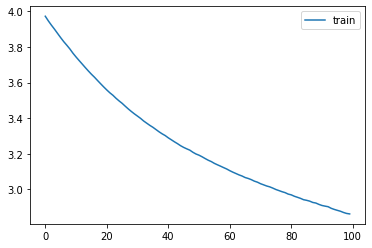

In [38]:
from matplotlib import pyplot
pyplot.plot(final_history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
final_model.save('Positive_model.h5')
model_file = drive.CreateFile({'title' : 'Positive_model.h5'})                       
model_file.SetContentFile('Positive_model.h5')                       
model_file.Upload()

In [45]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def getText(x):
  sid = SentimentIntensityAnalyzer()
  sentence = []
  for j in (x):
      if(j!=0):
          sentence.append(x_tokenizer.index_word[j])
  sent = ' '.join(sentence)
  return sent
  #print(sent)
  #print("Sentiment = ",sid.polarity_scores(sent))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
def changeInput(x):
  x_1 = []
  x_1.append(x)
  sample = x_tokenizer.texts_to_sequences(x_1)
  sample_1    =   pad_sequences(sample,  maxlen=max_text_len, padding='post')
  return sample_1

In [0]:
def getSentence(x):
  sid = SentimentIntensityAnalyzer()

  ans = final_model.predict(x)
  ans = np.reshape(ans,(ans.shape[1],ans.shape[2]))
  b = []

  for i in range(10):
      b.append(np.argmax(ans[i,:]))
  
  predicted = []
  for j in (b):
      if(j!=0):
          predicted.append(x_tokenizer.index_word[j])
  sent = ' '.join(predicted)
  return sent
  #print(sent)
  #print("Sentiment = ",sid.polarity_scores(sent))

In [33]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving abstract_predicted_data.csv to abstract_predicted_data.csv
User uploaded file "abstract_predicted_data.csv" with length 33470 bytes


In [0]:
abs_data = pd.read_csv('abstract_predicted_data.csv')

x = abs_data['abs_predicted']
x_new = []

for i in x:
  x_new.append(changeInput(i))

In [0]:
positive_in = []
positive_out = []

for i in range(len(x_new)):
  positive_in.append(getText(x_new[i][0]))
  positive_out.append(getSentence(x_new[i:i+1][0]))
  #print("Original :", getText(x_new[i][0]))
  #print("Predicted :", getSentence(x_new[i:i+1][0]))
  #print('\n')

In [0]:
df_pos = pd.DataFrame({'original':positive_in,'pos_predicted':positive_out})
export_csv = df_pos.to_csv ('Positive_model_output.csv', index = None, header=True)

In [66]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving extract_predicted_data.csv to extract_predicted_data (1).csv
User uploaded file "extract_predicted_data.csv" with length 1416012 bytes


In [0]:
ex_data = pd.read_csv('extract_predicted_data (1).csv')

x = ex_data['ex_predicted']
x_new = []
x_hat = []

for i in x:
  if(len(i.split())<=30):
    x_hat.append(i)

for i in x_hat:
  x_new.append(changeInput(i))

In [70]:
x[100]

'Air India spokesperson, Dhananjay Kumar, confirmed the incident and said that taking safety as priority, the pilot took necessary precautions before taking off the flight.'

In [0]:
positive_in = []
positive_out = []

for i in range(len(x_new)):
  positive_in.append(getText(x_new[i][0]))
  positive_out.append(getSentence(x_new[i:i+1][0]))

In [0]:
df_pos = pd.DataFrame({'original':positive_in,'pos_predicted':positive_out})
export_csv = df_pos.to_csv ('Positive_model_output_ex.csv', index = None, header=True)

In [73]:
print(positive_in[200])
print(positive_out[200])


metro officials have finally and said that hindi will be removed from all stations
that users have finally and said that hindi will be


In [62]:
encoder_inputs = Input(shape=(max_text_len, ), dtype='int32',)
encoder_embedding = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
encoder_LSTM = LSTM(hidden_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
#print(encoder_embedding.shape)

units = int(int(encoder_LSTM.trainable_weights[0].shape[1])/4)
#print("No units: ", units)
W = encoder_LSTM.get_weights()[0]
W_c = W[:, units * 2: units * 3]
#print(W_c.shape)
#print(state_c.shape)

pos_sentiment_memory = Memory(embedding_dim,alpha)
m_bar = pos_sentiment_memory(att_neg,context_attention_neg,encoder_embedding)

state_c1 = state_c + m_bar@W_c

decoder_embedding = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

dense_layer = Dense(x_voc, activation='softmax')
outputs = dense_layer(decoder_outputs)
final_model_1 = Model(encoder_inputs, outputs)

final_model_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 128)      3487744     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 128)      3487744     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60), (None,  45360       embedding_3[0][0]                
____________________________________________________________________________________________

In [0]:
final_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [64]:
final_history_1 = final_model_1.fit((x_neg*context_attention_neg),x_neg, epochs=50 , batch_size=256)

Train on 30732 samples
Epoch 1/50
30732/30732 [==============================] - 28s 897us/sample - loss: 7.6168
Epoch 2/50
30732/30732 [==============================] - 26s 848us/sample - loss: 6.2206
Epoch 3/50
30732/30732 [==============================] - 26s 847us/sample - loss: 5.9936
Epoch 4/50
30732/30732 [==============================] - 26s 850us/sample - loss: 5.8128
Epoch 5/50
30732/30732 [==============================] - 26s 849us/sample - loss: 5.7254
Epoch 6/50
30732/30732 [==============================] - 26s 845us/sample - loss: 5.6601
Epoch 7/50
30732/30732 [==============================] - 26s 841us/sample - loss: 5.5909
Epoch 8/50
30732/30732 [==============================] - 25s 827us/sample - loss: 5.5087
Epoch 9/50
30732/30732 [==============================] - 26s 832us/sample - loss: 5.4329
Epoch 10/50
30732/30732 [==============================] - 25s 826us/sample - loss: 5.3599
Epoch 11/50
30732/30732 [==============================] - 25s 827us/sample 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
final_model_1.save('Negative_model.h5')
model_file = drive.CreateFile({'title' : 'Negative_model.h5'})                       
model_file.SetContentFile('Negative_model.h5')                       
model_file.Upload()

In [0]:
def getSentence_neg(x):
  sid = SentimentIntensityAnalyzer()

  ans = final_model_1.predict(x)
  ans = np.reshape(ans,(ans.shape[1],ans.shape[2]))
  b = []

  for i in range(max_text_len):
      b.append(np.argmax(ans[i,:]))
  
  predicted = []
  for j in (b):
      if(j!=0):
          predicted.append(x_tokenizer.index_word[j])
  sent = ' '.join(predicted)
  return sent
  #print(sent)
  #print("Sentiment = ",sid.polarity_scores(sent))

In [0]:
x = abs_data['abs_predicted']
x_new = []

for i in x:
  x_new.append(changeInput(i))

positive_in = []
positive_out = []

for i in range(len(x_new)):
  positive_in.append(getText(x_new[i][0]))
  positive_out.append(getSentence_neg(x_new[i:i+1][0]))

In [80]:
print(positive_in[20])
print(positive_out[20])

shares look shares picture of
shares look shares at of the the of the the the the the the of


In [0]:
df_neg = pd.DataFrame({'original':positive_in,'neg_predicted':positive_out})
export_csv = df_neg.to_csv ('Negative_model_output_abs.csv', index = None, header=True)

In [0]:
x = ex_data['ex_predicted']
x_new = []
x_hat = []

for i in x:
  if(len(i.split())<=30):
    x_hat.append(i)

for i in x_hat:
  x_new.append(changeInput(i))

In [0]:
positive_in = []
positive_out = []

for i in range(len(x_new)):
  positive_in.append(getText(x_new[i][0]))
  positive_out.append(getSentence_neg(x_new[i:i+1][0]))

In [0]:
df_neg = pd.DataFrame({'original':positive_in,'neg_predicted':positive_out})
export_csv = df_neg.to_csv ('Negative_model_output_ex.csv', index = None, header=True)